<a href="https://colab.research.google.com/github/aldebaro/ai6g/blob/main/09_rl_based_radio_resource_allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inteligência Artificial e Aprendizado de Máquina Aplicados a Redes 5G e 6G**.
*Aldebaro Klautau* (UFPA). Minicurso 5 do SBrT - 25 de setembro de 2022.

In [ ]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    import sys
    import os
    try:
      !git clone https://github.com/aldebaro/ai6g.git
    except:
      print("ai6g is already in the contents")
    %cd ai6g
    !pip install -r requirements.txt

In [1]:
%cd ./files_09_rl/

/home/vagrant/ai6g/files_09_rl


# Simple scenario with 1 basestation and 4 UEs

We use the [sixg_radio_mgmt simulator](https://github.com/lasseufpa/sixg_scheduling_example) to create the scenario. The configuration files are stored in the `n9_rrs_rl/env_config/` folder. We can edit the config file in order to deploy the desired communication system scenario. The `n9_rrs_rl/env_config/simple_rr.yml` file in the cell below defines a scenario with 1 basestation, where the basestation has 8 resource blocks (RBs - Allocation unit). There are 4 UEs in the system (all associated to the basestation). Therefore, the 8 RBs available in the basestation should be distributed among the 4 UEs in accordance with the scheduler agent's decision in each step.

![Scheduling example](files_09_rl/sbrt_scheduling_minicourse.png)

To facilitate our problem interpretation, we configured the simulator to consider that 1 packet is transmitted per RB. So every time an RB is allocated to a UE, the UE can transmit 1 packet.

We implemented a simple traffic scenario in `n9_rrs_rl/traffics/simple.py` file that defines the traffic as a random number of packets between 2 and 4 for UEs 1 and 2, and between 0 and 2 for UEs 3 and 4. Therefore UEs 1 and 2 will always receive more packets than UEs 3 and 4.

### Executing a round-robin agent in the configured environment


Let's create the communication environment using the `CommunicationEnv` from `sixg_radio_mgmt`. The string `"simple_rr"` used as an argument in the `CommunicationEnv` creation tells the environment to create the scenario described in `n9_rrs_rl/env_config/simple_rr.yml` already described in this tutorial. We also pass the `SimpleChannel`, `SimpleTraffic` and `SimpleMobility` used by the communication environment.

In [2]:
import numpy as np
from tqdm import tqdm

from agents.round_robin import RoundRobin
from channels.simple import SimpleChannel
from mobilities.simple import SimpleMobility
from sixg_radio_mgmt import CommunicationEnv
from traffics.simple import SimpleTraffic

seed = 7
rng = np.random.default_rng(seed)
# Creating the communication environment with the configurations defined in the config file
comm_env = CommunicationEnv(
    SimpleChannel, # Channel class implementing a constant spectral efficiency for all UEs with value 1
    SimpleTraffic, # Class implementing the traffic behavior explained before
    SimpleMobility, # Class implementing the UEs movement (this information is not used in this simple scenario)
    "simple_rr", # Specifies the name of the environment config file
    rng=rng,
)

In the code cell below we instantiate the round-robin agent passing the communication environment, the number of UEs, number of basestations, and the number of available RBs in the basestation.

In [3]:
round_robin = RoundRobin(
                comm_env,  # Communication environment
                4, # Max number of UEs
                1, # Max number of basestations
                np.array([8])) # Number of RBs available in each basestation
# Here we set the agent functions used in the communication environment                
comm_env.set_agent_functions(
    round_robin.obs_space_format,
    round_robin.action_format,
    round_robin.calculate_reward,
)

Finally, in the code cell below, we create the interaction between the round-robin agent and the environment. The `round_robin.step(obs)` receives the `obs` variable from the communication environment filtered with `obs_space_format()` function provided by the agent. The `round_robin.step(obs)` generated the `sched_decision` that it is after applied in the `comm_env.step(sched_decision)` distributing the RBs among the UEs.

In [4]:
obs = comm_env.reset()
number_steps = 10
# Testing the agent using 10 TTIs (steps)
for step_number in tqdm(np.arange(comm_env.max_number_steps)):
    sched_decision = round_robin.step(obs)
    obs, _, end_ep, _ = comm_env.step(sched_decision)
    if end_ep:
        comm_env.reset()

100%|██████████| 10/10 [00:00<00:00, 47.62it/s]


When the process finishes, it generates a log file containing all the network information data generated in each step of the simulation in the folder `n9_rrs_rl/hist/` with the name of the simulation. Let's take a look at the information generated.

In [5]:
hist_rr = comm_env.metrics_hist.read("./", "simple_rr", 1) # (root_path, simulation_name, episode_number)
print("Collected information: ", list(hist_rr.keys())) # All variables stored in the log file
print("Scheduling decisions: \n",hist_rr["sched_decision"][0:2])
# The round-robin always schedules 2 RB for each UE in each basestation

Collected information:  ['pkt_incoming', 'pkt_throughputs', 'pkt_effective_thr', 'buffer_occupancies', 'buffer_latencies', 'dropped_pkts', 'mobility', 'spectral_efficiencies', 'basestation_ue_assoc', 'basestation_slice_assoc', 'slice_ue_assoc', 'sched_decision', 'reward', 'slice_req']
Scheduling decisions: 
 [[[[1. 0. 0. 0. 1. 0. 0. 0.]
   [0. 1. 0. 0. 0. 1. 0. 0.]
   [0. 0. 1. 0. 0. 0. 1. 0.]
   [0. 0. 0. 1. 0. 0. 0. 1.]]]


 [[[1. 0. 0. 0. 1. 0. 0. 0.]
   [0. 1. 0. 0. 0. 1. 0. 0.]
   [0. 0. 1. 0. 0. 0. 1. 0.]
   [0. 0. 0. 1. 0. 0. 0. 1.]]]]


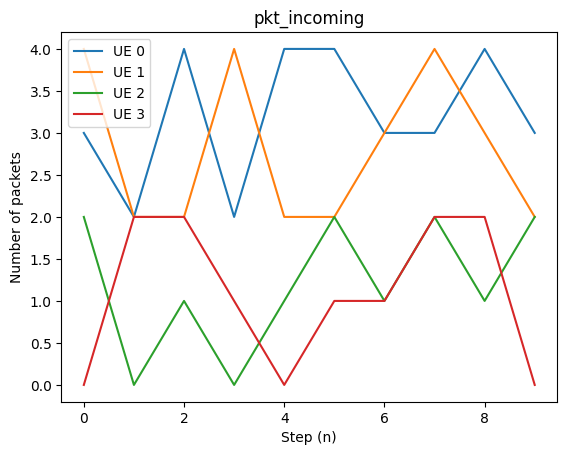

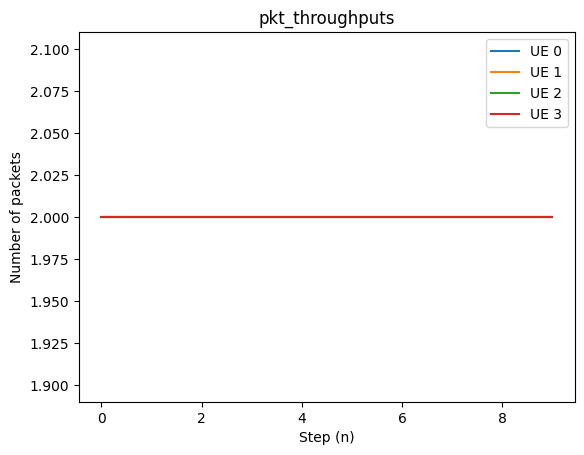

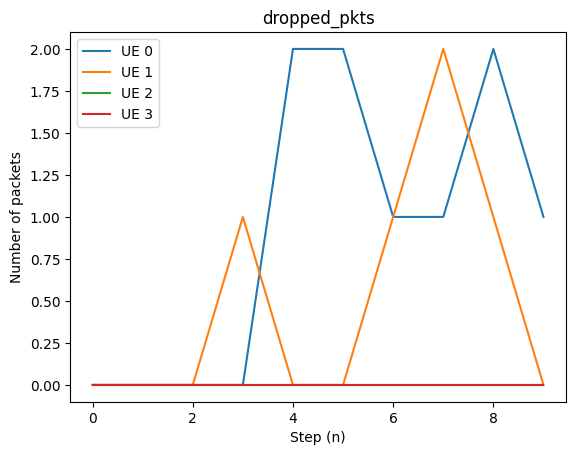

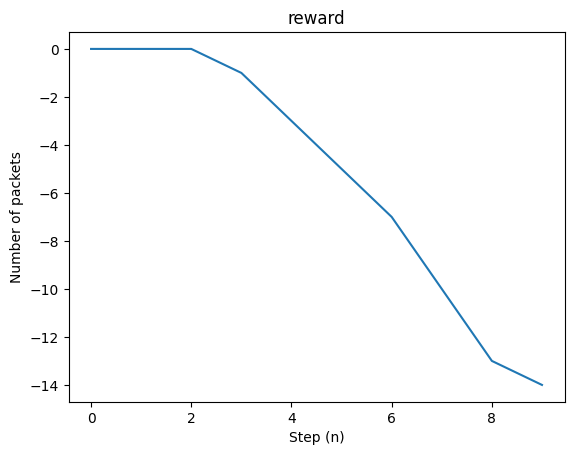

In [6]:
import matplotlib.pyplot as plt
metrics = ['pkt_incoming', 'pkt_throughputs', 'dropped_pkts', 'reward']

# Plotting metrics obtained using Round-robin
def plot_metrics(hist, metrics):
	for metric in metrics:
		plt.figure()
		if metric == "reward":
			plt.plot(np.cumsum(hist[metric]))
		else:
			for ue in np.arange(comm_env.max_number_ues):
				plt.plot(hist[metric][:,ue], label="UE {}".format(ue))
			plt.legend()
		plt.title(metric)
		plt.xlabel("Step (n)")
		plt.ylabel("Number of packets")
		plt.show()

plot_metrics(hist_rr, metrics)

### Implementing a simple RL agent to reduce the packet loss in the same scenario

Using the same `Agent` class from `sixg_radio_mgmt` scenario, we created a simple RL agent based on a Soft-actor critic (SAC) implementation from [Stable-baselines3 library](https://github.com/DLR-RM/stable-baselines3) (agent's code in the cell below).

In [7]:
from typing import Union

import numpy as np
from gym import spaces
from stable_baselines3.sac.sac import SAC

from sixg_radio_mgmt import Agent, CommunicationEnv


class RLSimple(Agent):
    def __init__(
        self,
        env: CommunicationEnv,
        max_number_ues: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        hyperparameters: dict = {},
        seed: int = np.random.randint(1000),
    ) -> None:
        super().__init__(
            env, max_number_ues, max_number_basestations, num_available_rbs, seed
        )
        # Creating the stablebaseline Soft-actor critic (SAC) agent
        self.agent = SAC(
            "MlpPolicy",
            env,
            verbose=0,
            tensorboard_log="./tensorboard-logs/",
            seed=self.seed,
            learning_rate=0.0003,
            gamma=0.99,
            batch_size=256,
            gradient_steps=1,
        )

    def step(self, obs_space: Union[np.ndarray, dict]) -> np.ndarray:
        # Generates an prediction using the trained agent based on observation space from communication environment
        return self.agent.predict(np.asarray(obs_space), deterministic=True)[0]

    def train(self, total_timesteps: int) -> None:
        # Train the agent using the total number of steps specified
        self.agent.learn(total_timesteps=int(total_timesteps), callback=[])

    @staticmethod
    def obs_space_format(obs_space: dict) -> np.ndarray:
        # Create a formatted observation space to be used by the RL agent filtering the environment information
        formatted_obs_space = np.array([])
        hist_labels = [
            "pkt_incoming",
            "dropped_pkts",
            "pkt_effective_thr",
            "buffer_occupancies",
            'buffer_latencies',
        ]
        for hist_label in hist_labels:
            formatted_obs_space = np.append(
                formatted_obs_space, obs_space[hist_label], axis=0
            )
        # Formatted obs. space contains 2 metrics from each UE, totalizing 2*4(UEs) = 8 values
        return formatted_obs_space

    @staticmethod
    def calculate_reward(obs_space: dict) -> float:
        # Define the RL agent reward function, therefore the agent will learn to avoid dropped packets
        reward = -np.sum(obs_space["dropped_pkts"])
        return reward

    @staticmethod
    def get_action_space() -> spaces.Box:
        # Action space required by the stablebaselines agent to define the number of outputs in the neural network
        number_available_rbs = 8 # Number of available RBs in the basestation
        return spaces.Box(low=-1, high=1, shape=(number_available_rbs,))

    @staticmethod
    def get_obs_space() -> spaces.Box:
        # Observation space required by the stablebaselines agent to define the number of inputs in the neural network
        number_of_metrics = 5 # Number of metrics in the formatted observation space 
        number_ues = 4
        return spaces.Box(low=0, high=np.inf, shape=(number_of_metrics*number_ues,), dtype=np.float64)

    @staticmethod
    def action_format(
        action: np.ndarray,
    ) -> np.ndarray:
        # Transform the action output from neural network (RL agent) to the environment format using a sched
        # decision with dimensions BxUxR, where B represents the number of basestations, U the number of UEs
        # and R represents the number of RBs available in each basestation. An example of scheduling decision
        # for a scenario with 1 basestation, 2 UEs and 2 RBs per basestations should be [ [[1, 0], [0, 1]] ]
        # representing that in the first basestation, UE 1 the RB 1 was allocated. And the second RB was 
        # allocated to the UE 2 in the basestation 1.
        sched_decision = np.zeros((1,4,8))
        for i in np.arange(8):
            if action[i] < -0.5:
                sched_decision[0,0,i] = 1
            elif action[i] <= 0:
                sched_decision[0,1,i] = 1
            elif action[i] <= 0.5:
                sched_decision[0,2,i] = 1
            else:
                sched_decision[0,3,i] = 1
        
        return sched_decision


The RL soft-actor critic (SAC) method is an actor-critic based method that uses two different neural networks, Actor and Critic. In a general sense, the actor provides the actions to be taken in the environment. The critic provides feedback to the actor, trying to predict how good was the taken action in the given state for a defined RL goal. The neural network architectures below were generated using [Netron](netron.app).

### Actor neural network
The number of entries in the actor network is defined by the number of variables (features) in the observation space, and the number of outputs in the last layer is defined by the number of outputs defined in our action space. Therefore our actor neural network has 20 entries (5 features x 4 UEs) and 8 outputs (8 RBs). The stablebaselines3 uses 2 hidden layers with 256 neurons by default in the SAC implementation. 

![Actor network](./files_09_rl/net_arch_actor.png)

### Critic neural network
Differently from the actor network, the critic network displayed by Netron app should be read from the right to left layers. The number of entries in the critic network (first layer from right to left) is defined by the number of variables (features) in the observation space, and the number of outputs in the last layer is defined by the number of outputs defined in our action space (20 features observation space + 8 RB actions = 28). The output layer has an output of only a single value which is responsible for informing the actor how good the action taken in the given state in relation to the RL agent goal. The stablebaselines3 also uses 2 hidden layers with 256 neurons by default in the critic network of SAC implementation. 

![Critic network](./files_09_rl/net_arch_critic.png)

Now let's create the simulation to the RL agent

In [8]:
import numpy as np
from tqdm import tqdm

rng = np.random.default_rng(seed)
comm_env = CommunicationEnv( # Creating the communication environment
    SimpleChannel,
    SimpleTraffic,
    SimpleMobility,
    "simple_rl",
    rng=rng,
    obs_space=RLSimple.get_obs_space,
    action_space=RLSimple.get_action_space,
)
rl_agent = RLSimple(comm_env, 1, 4, np.array([8]), seed=seed) # Instantiate an RL agent
comm_env.set_agent_functions( # Assigning RL agent functions to th eenvironment
    rl_agent.obs_space_format, rl_agent.action_format, rl_agent.calculate_reward
)

# Training
total_number_steps = 5000
rl_agent.train(total_number_steps) # Training the RL Agent

# Test
total_number_steps_test = 10
comm_env.rng = np.random.default_rng(seed)
obs = comm_env.reset()
for step_number in tqdm(np.arange(total_number_steps_test)):
    sched_decision = rl_agent.step(obs)
    obs, _, end_ep, _ = comm_env.step(sched_decision)
    if end_ep:
        comm_env.reset()


2022-09-19 12:49:19.391025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 12:49:19.571475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 12:49:19.571507: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-19 12:49:19.602218: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-19 12:49:20.443250: W tensorflow/stream_executor/platform/de

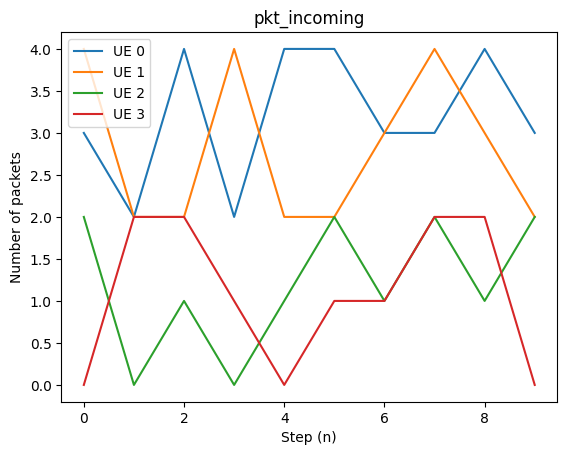

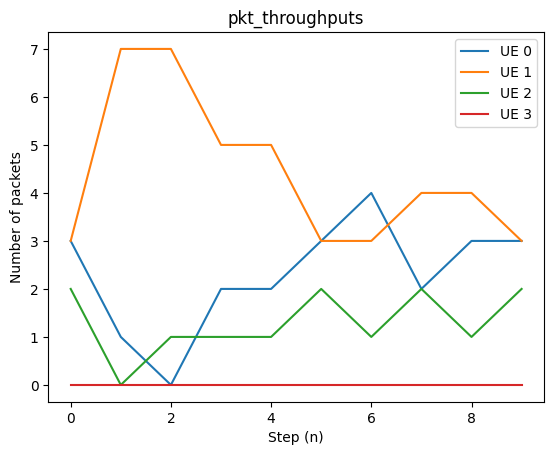

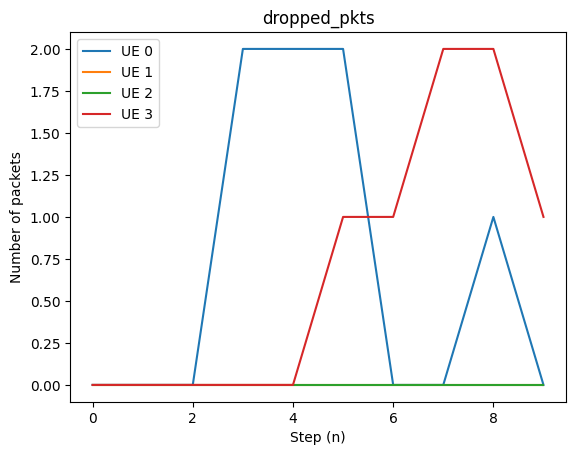

In [9]:
hist_rl = comm_env.metrics_hist.read("./", "simple_rl", 1)
metrics = ['pkt_incoming', 'pkt_throughputs', 'dropped_pkts']
plot_metrics(hist_rl, metrics)

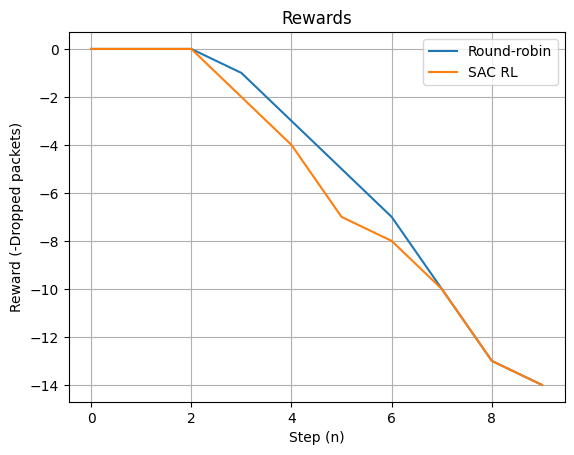

In [10]:
# Reward comparison between round-robin and RL
plt.figure()
plt.plot(np.cumsum(hist_rr["reward"]), label="Round-robin")
plt.plot(np.cumsum(hist_rl["reward"]), label="SAC RL")
plt.legend()
plt.title("Rewards")
plt.xlabel("Step (n)")
plt.ylabel("Reward (-Dropped packets)")
plt.grid()
plt.show()

### Tips to improve the RL agent:
- Increasing the number of training steps
- Selecting more appropriate features to the observation space
- Tuning hyperparameters
- Normalizing the observation space
- Exploring new action spaces

## Authors

- [Cleverson Veloso Nahum - LASSE/UFPA](https://github.com/cleversonahum)